<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 3: прогнозирование временных рядов</center></h2>

In [6]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import warnings
import gdown
import pandas as pd
import numpy as np
import seaborn as sns
from copy import deepcopy

warnings.filterwarnings("ignore")

In [9]:
from etna.datasets import TSDataset

В данной задаче мы будем решать одну из актуальных практических задач, с которыми, в том числе, сталкиваются разработчики ETNA - прогнозирование объема необходимой наличности в банкоматах (на примере одного устройства). Пожалуй, ни для кого не секрет, что отсутствие необходимой суммы в банкомате не делает клиента банка счастливее. В то же время, избыток заправленной в банкомат наличности приводит к упущенной выгоде - ведь, в конечном счете, эти деньги могли быть размещены в качестве краткосрочного депозита на межбанковском рынке. Для кредитной организации с обширной сетью банкоматов даже незначительное улучшение качества предсказания способно внести значительный вклад в прибыльность этой ветки бизнеса. 

Мы будем использовать дневные данные реального банкомата хоть и не с российского рынка, но очень схожего с ним - турецкого. Скачаем и загрузим их:

In [10]:
url = 'https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv'
output = 'atm_daily_cash.csv'
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

df = pd.read_csv('atm_daily_cash.csv')
df = df[4:] #лучше избавиться от нескольких пропущенных значений в начале сразу,
            #могут доставлять ненужные лишние проблемы

Downloading...
From: https://raw.githubusercontent.com/andrei-egorov/ml_se_seminars/master/atm_daily_cash.csv
To: /content/atm_daily_cash.csv
26.1kB [00:00, 15.7MB/s]                   


Взглянем на то, что представляют из себя данные:

In [11]:
df.head()

,Date,CashIn,CashOut
4,1/5/2016,20840.0,22200.0
5,1/6/2016,28460.0,18810.0
6,1/7/2016,19250.0,23210.0
7,1/8/2016,49770.0,4350.0
8,1/9/2016,NaN,NaN


В нашем распоряжении пополнения и изъятия; нас интересует нетто. Для этого будем учитывать изъятия со знаком минус, а нетто определим как сумму (такое представление пригодится нам в дальнейшем).

In [12]:
df['CashOut'] = -df['CashOut']
df['target'] = df['CashIn'] + df['CashOut']

In [13]:
df.head()

,Date,CashIn,CashOut,target
4,1/5/2016,20840.0,-22200.0,-1360.0
5,1/6/2016,28460.0,-18810.0,9650.0
6,1/7/2016,19250.0,-23210.0,-3960.0
7,1/8/2016,49770.0,-4350.0,45420.0
8,1/9/2016,NaN,NaN,NaN


### Задание 1. EDA (1 балл)

Проведите разведывательный анализ данных - постройте графики, на которых можно судить о наличии тренда, сезонности и прочих зависимостей. Проанализируйте корреляции. Какие выводы вы можете сделать?

<Axes: >

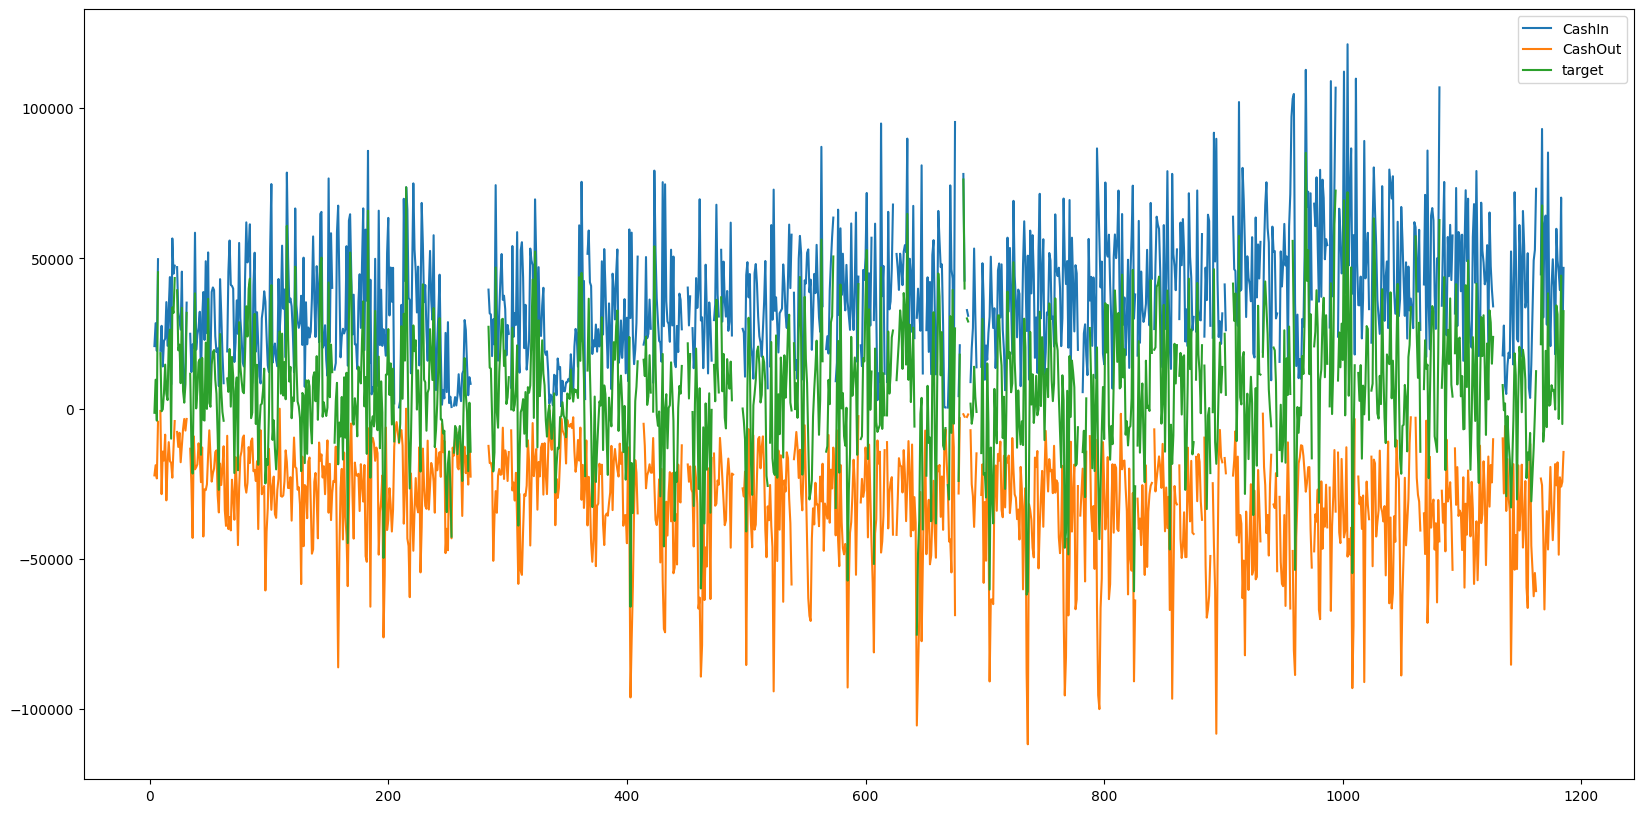

In [14]:
df.plot(figsize = (20, 10))

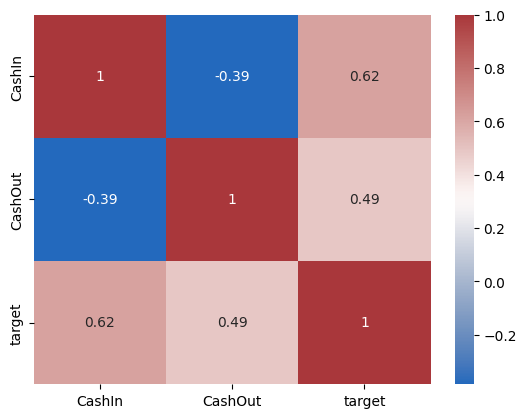

In [55]:
cmap = sns.color_palette("vlag", as_cmap=True)
sns.heatmap(df.corr("pearson"), annot=True, cmap=cmap);

Ответ: У CashIn и CashOut отрицательная корреляция. Это может быть объяснено тем, что есть общая тенденция по стране: снимать деньги при каких-то неблагоприятных событиях и наоборот копить, когда более стабильная ситуация. Следовательно либо все снимают деньги и никто не кладет, либо все кладут деньги и гораздо меньше снимает. Сезонность проанализировать тяжело, скорее всего она где-то месячная судя по пикам, которых как раз примерно столько, сколько месяцев.

### Задание 2. Приведение в формат multi-segment (0.75 балла)

Теперь нам предстоит (в первый раз) привести данные к формату, в котором с ними будет возможно работать средствами ETNA. Вначале мы будем рассматривать и предсказывать наши данные как мульти-сегментные. Чтобы привести данные в соответствующий формат, вам пригодится функция `pd.melt`. На выходе у нас должен получиться объект `TSDataset`. Поскольку мы будем смотреть на данные не только в этом разрезе, лучше не менять исходный датафрейм и работать с копией.

In [15]:
df2 = df.melt(id_vars=['Date'], value_vars=['CashIn', 'CashOut', 'target'])
df2['timestamp'] = pd.to_datetime(df2['Date'])
df2.drop(columns="Date", inplace=True)
df2 = df2.rename(columns={'variable' : 'segment' ,'value' : 'target'})
df2

,segment,target,timestamp
0,CashIn,20840.0,2016-01-05
1,CashIn,28460.0,2016-01-06
2,CashIn,19250.0,2016-01-07
3,CashIn,49770.0,2016-01-08
4,CashIn,NaN,2016-01-09
...,...,...,...
3541,target,-3440.0,2019-03-27
3542,target,16640.0,2019-03-28
3543,target,44310.0,2019-03-29
3544,target,-5100.0,2019-03-30


In [16]:
df_ts_format = TSDataset.to_dataset(df2)
ts = TSDataset(df_ts_format, "D")
ts

segment,CashIn,CashOut,target
feature,target,target,target
timestamp,,,
2016-01-05,20840.0,-22200.0,-1360.0
2016-01-06,28460.0,-18810.0,9650.0
2016-01-07,19250.0,-23210.0,-3960.0
2016-01-08,49770.0,-4350.0,45420.0
2016-01-09,NaN,NaN,NaN
...,...,...,...
2019-03-27,45160.0,-48600.0,-3440.0
2019-03-28,39480.0,-22840.0,16640.0


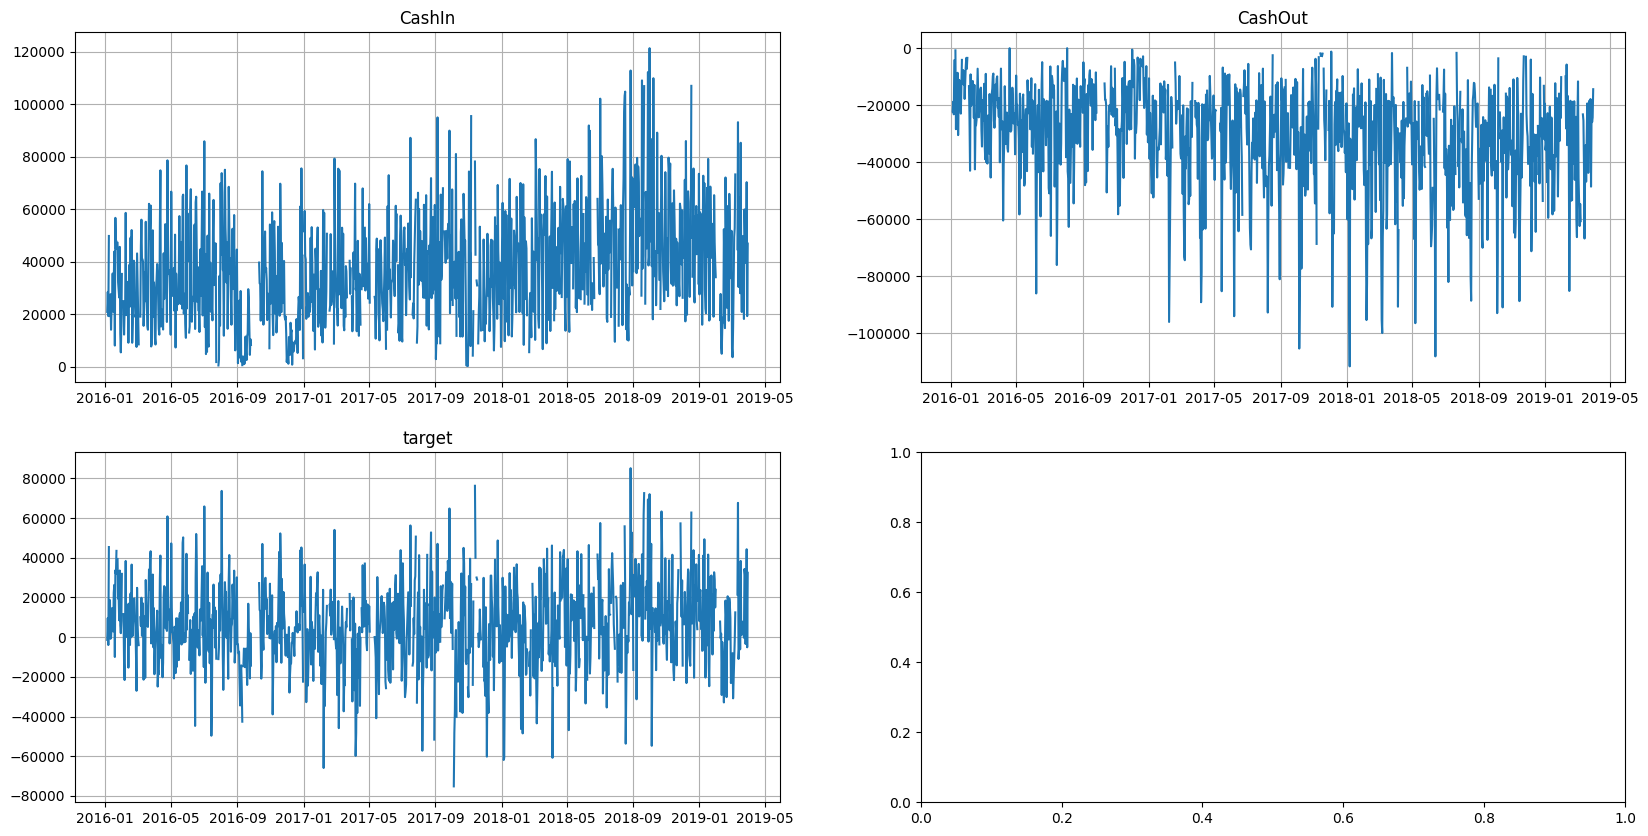

In [17]:
ts.plot()

### Задание 3. Работа с пропущенными значениями и аутлаерами (1 балл)

Проанализируйте, есть ли в данных пропущенные значения, и подберите оптимальный метод их заполнения средствами ETNA. Какие методы вы выберете и почему? Совет: возможно, лучше сохранить заполненные данные в отдельный объект, поскольку некоторые модели заполняют пропуски встроенными методами, и подача на вход "сырых" данных (на языке временных рядов это данные с нерегулярными интервалами) может принести лучший результат.

Импорты всех необходимых компонент произведите самостоятельно.

Сначала я попробовала медианный метод, но он выделил всего несколько неподходящих пиков, причем чем больше было окно, тем хуже. денсити сработал гораздо лучше - он отметил как раз бросающиеся в глаза пики. оэтому я выбрала именно его. 

In [18]:
df2.isnull().sum()

segment        0
target       299
timestamp      0
dtype: int64

In [19]:
from etna.models import ProphetModel
from etna.analysis import (
    get_anomalies_median,
    get_anomalies_density,
    get_anomalies_prediction_interval,
    get_anomalies_hist,
)
from etna.analysis import plot_anomalies

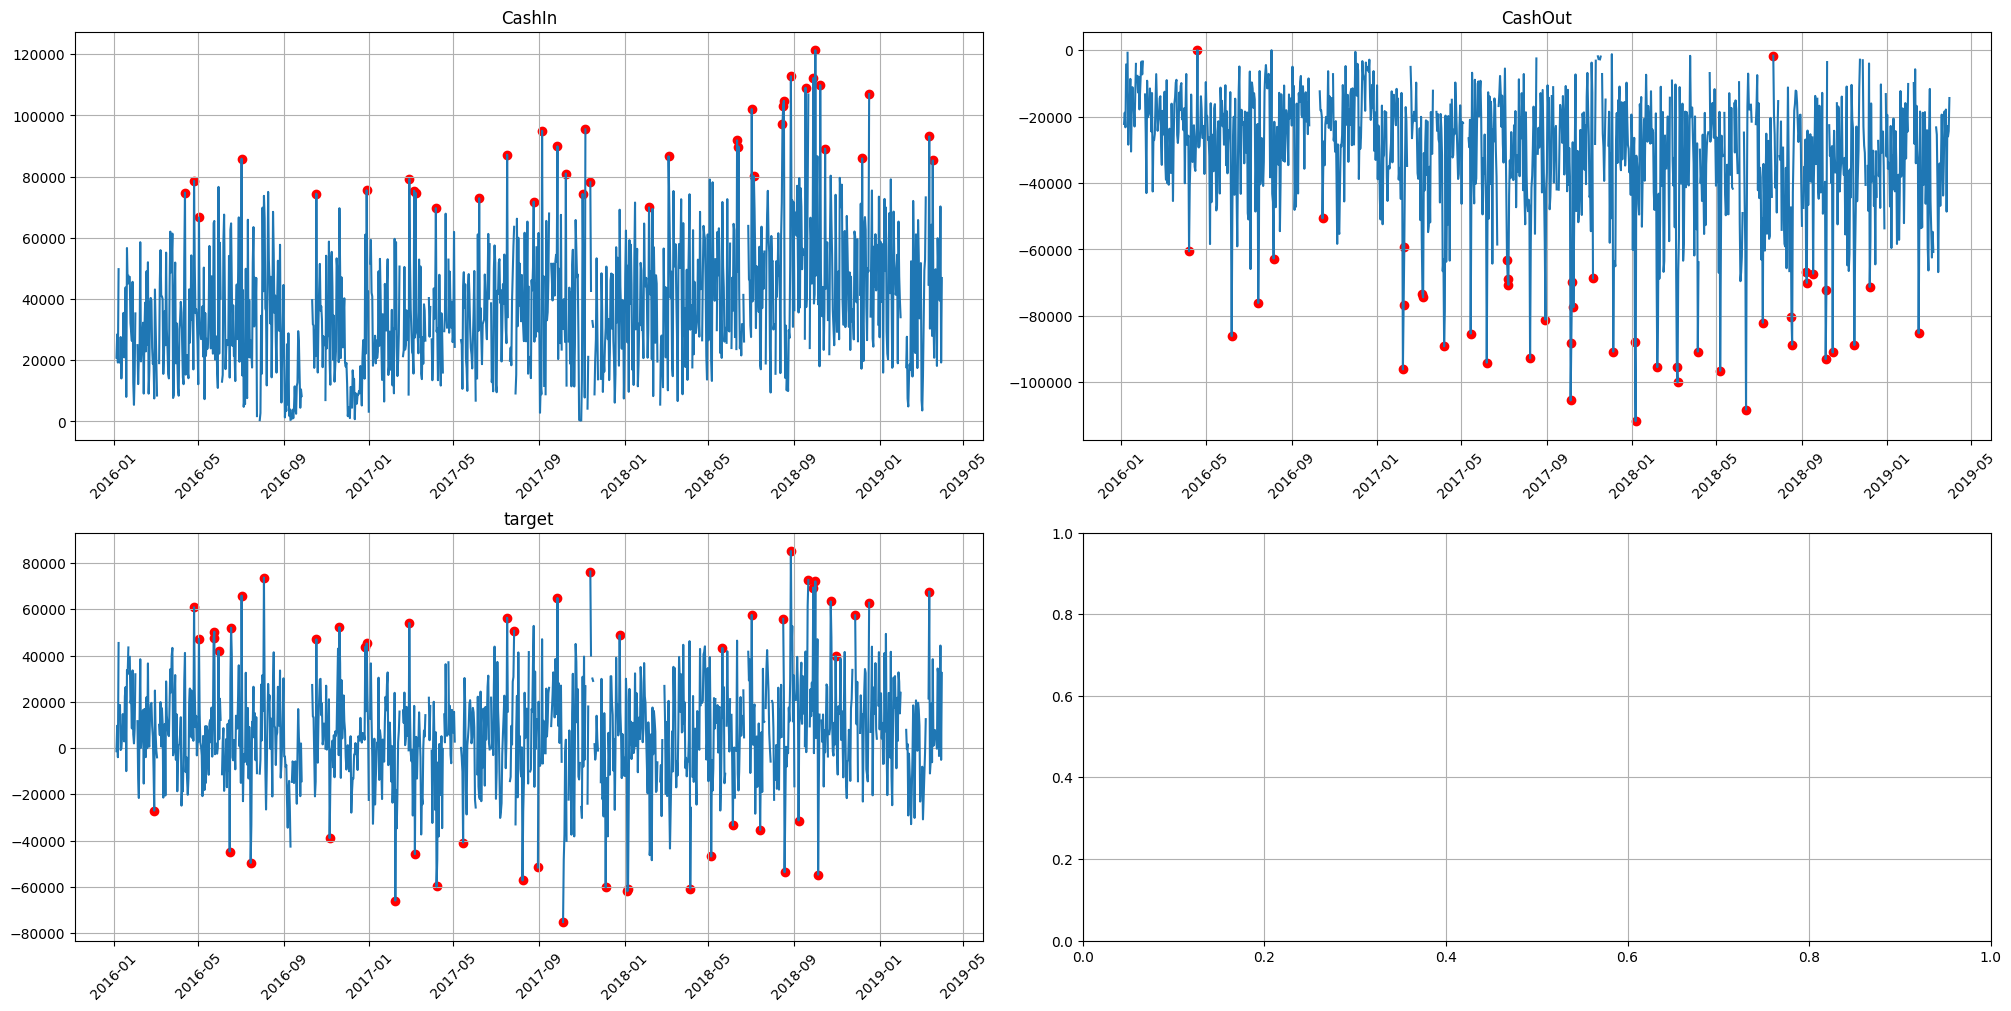

In [20]:
anomaly_dict = get_anomalies_density(ts, window_size=18, distance_coef=1, n_neighbors=4)
plot_anomalies(ts, anomaly_dict)

In [21]:
from etna.transforms import DensityOutliersTransform, TimeSeriesImputerTransform
from etna.analysis import plot_imputation

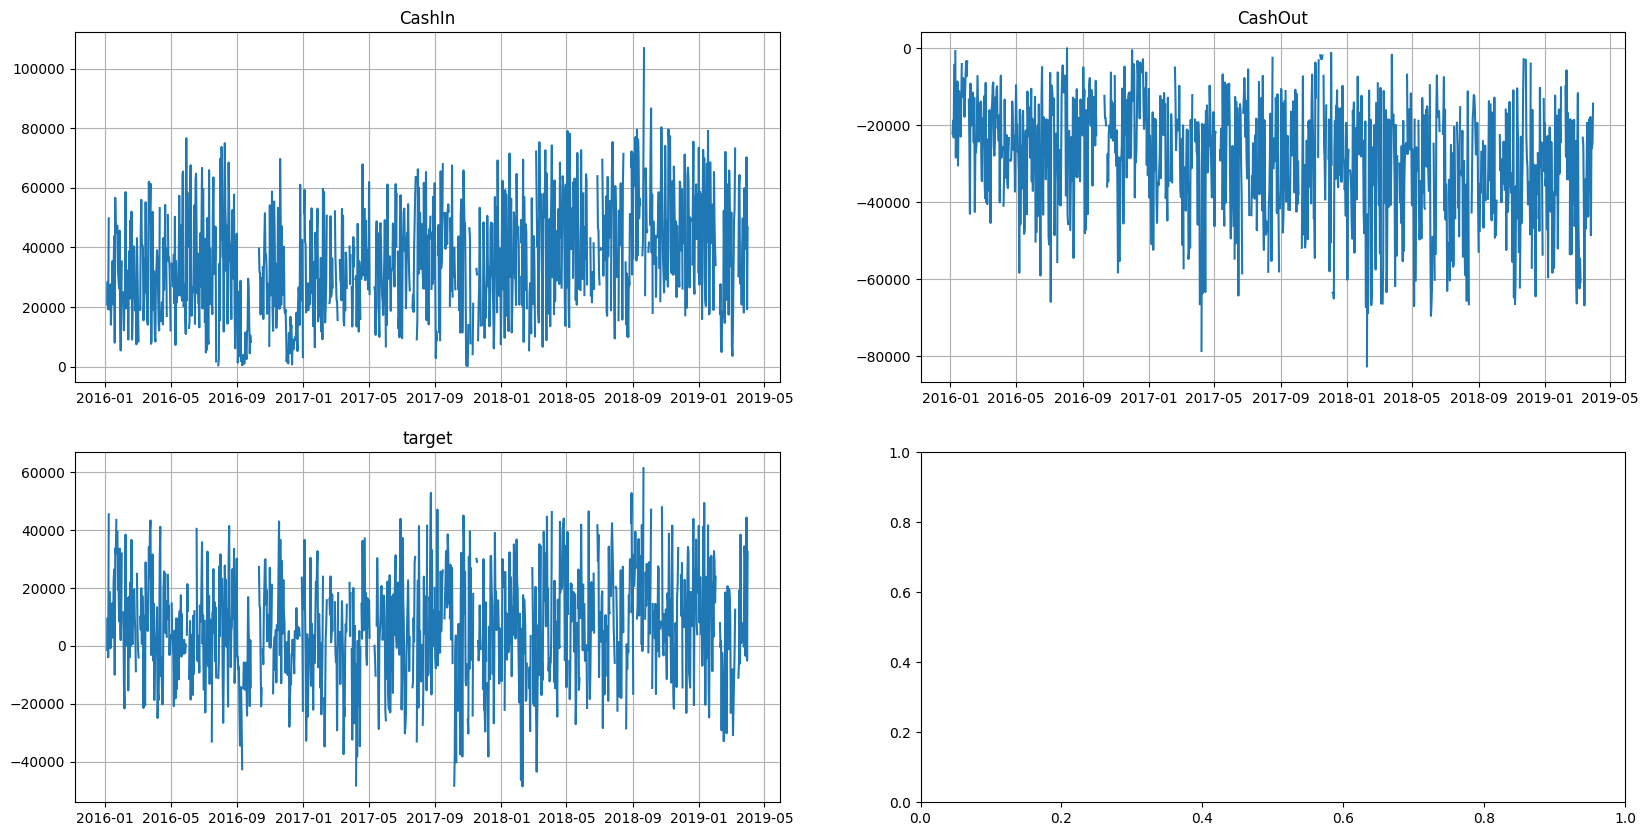

In [22]:
outliers_remover = DensityOutliersTransform(in_column="target", window_size=18, distance_coef=1, n_neighbors=4)

ts.fit_transform([outliers_remover])
ts.plot()

In [23]:
outliers_imputer = TimeSeriesImputerTransform(in_column="target", strategy="running_mean")

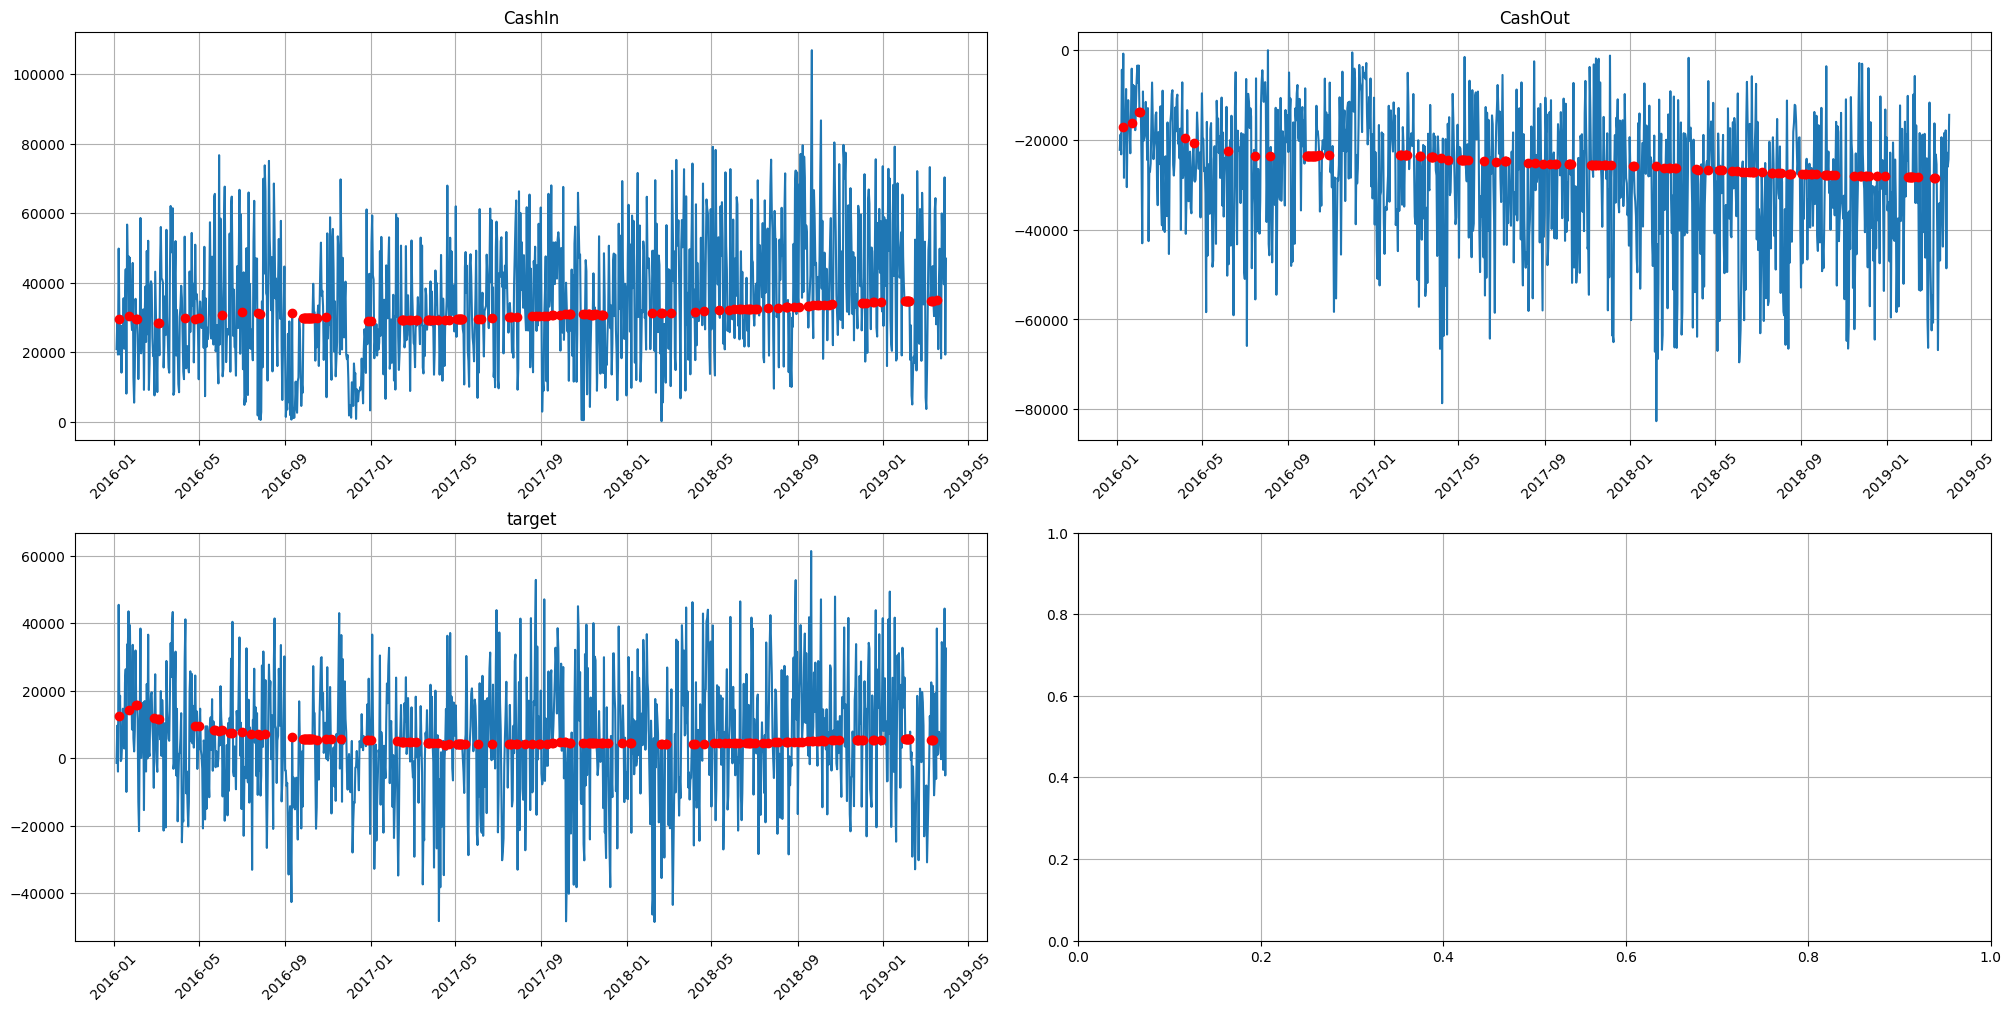

In [24]:
plot_imputation(imputer=outliers_imputer, ts=ts)

In [25]:
ts.fit_transform([outliers_imputer])

In [26]:
ts


segment,CashIn,CashOut,target
feature,target,target,target
timestamp,,,
2016-01-05,20840.0,-22200.0,-1360.0
2016-01-06,28460.0,-18810.0,9650.0
2016-01-07,19250.0,-23210.0,-3960.0
2016-01-08,49770.0,-4350.0,45420.0
2016-01-09,29580.0,-17142.5,12437.5
...,...,...,...
2019-03-27,45160.0,-48600.0,-3440.0
2019-03-28,39480.0,-22840.0,16640.0


Проверьте ряды на наличие аутлаеров, и очистите их соответствующим образом. Обоснуйте выбор.

Описала выбор выше.

In [27]:
#YOUR CODE HERE#

### Задание 4. Построение мультисегментной модели (1.25 балла)

Постройте мульти-сегментную модель на основе Prophet, и оцените качество по SMAPE на кросс-валидации. В качестве горизонта предсказания возьмите 5 дней - этого же горизонта будем придерживаться и в дальнейшем.

Отрисуйте получившийся прогноз.

In [28]:
from etna.pipeline import Pipeline
from etna.models import ProphetModel
from etna.metrics import SMAPE, MAE
from etna.analysis import plot_backtest

In [29]:

HORIZON = 5
model = ProphetModel()

In [30]:
pipeline = Pipeline(model=model,  horizon=HORIZON)

In [31]:
metrics, forecasts, _ = pipeline.backtest(
    ts, metrics=[SMAPE()], aggregate_metrics=True, n_folds=2
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphl58x9z9/8wndctu_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphl58x9z9/d16g1f8c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8851', 'data', 'file=/tmp/tmphl58x9z9/8wndctu_.json', 'init=/tmp/tmphl58x9z9/d16g1f8c.json', 'output', 'file=/tmp/tmpuvr17pgj/prophet_model-20230518180220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to

In [32]:
metrics

,segment,SMAPE
0,CashIn,25.422849
1,CashOut,41.450693
2,target,124.390859


Исходя из статистики по каждому ряду, какой можно сделать вывод о том, как лучше предсказывать итоговое значение? Посчитайте то же самое исходя из MAE.

In [33]:
metrics, forecasts, _ = pipeline.backtest(
    ts, metrics=[MAE()], aggregate_metrics=True, n_folds=2
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphl58x9z9/08t5pusw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphl58x9z9/qb_yajz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15769', 'data', 'file=/tmp/tmphl58x9z9/08t5pusw.json', 'init=/tmp/tmphl58x9z9/qb_yajz0.json', 'output', 'file=/tmp/tmpcvskilpe/prophet_model-20230518180234.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

In [34]:
metrics

,segment,MAE
0,CashIn,9628.228768
1,CashOut,12518.777908
2,target,14851.008784


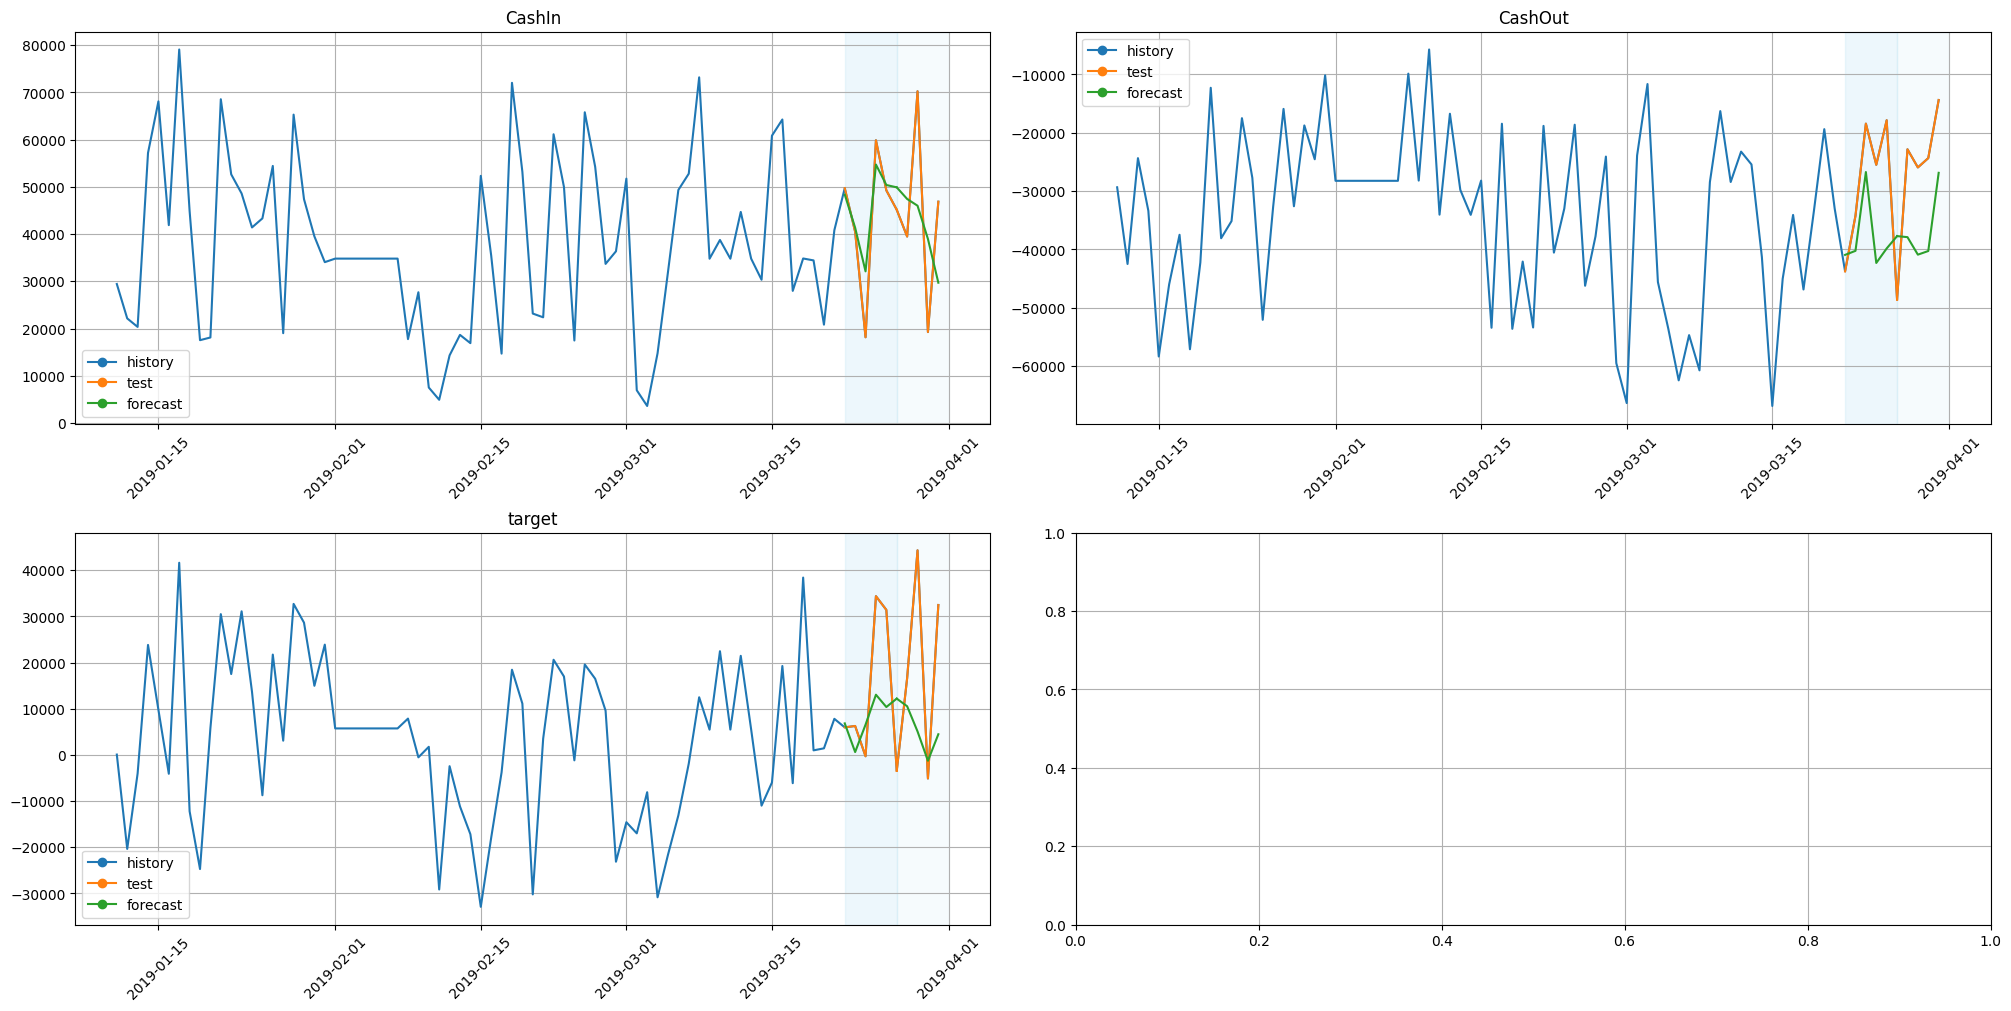

In [35]:
plot_backtest(forecasts, ts, history_len = 70)

### Задание 5. Иерархический временной ряд (2 балла)

Вопрос, поставленный в прошлом задании, тем не менее, естественным образом подводит нас к концепции **иерархического временного ряда** (когда один ряд состоит из других в качестве компонент). Это полезная концепция, которая может встретиться во многих задачах. В этом задании вам предстоит самостоятельно разобраться в деталях ее реализации в ETNA с использованием справочных материалов, предоставляемых библиотекой (как это часто бывает на практике). Они содержатся по следующей ссылке:

https://github.com/tinkoff-ai/etna/blob/master/examples/hierarchical_pipeline.ipynb

На выходе из первой части задания необходимо получить `TSDataset` с иерархической структурой, а также соответствующий реконсилятор, который позволит собирать искомый ряд из составных компонент. Классы, которые вам понадобятся, импортированы ниже.

In [36]:
from etna.datasets import HierarchicalStructure
from etna.pipeline import HierarchicalPipeline
from etna.reconciliation import BottomUpReconciliator

In [37]:
df_3 = df2[df2.segment != 'target']
hier_df = TSDataset.to_dataset(df = df_3)
hierarchical_structure = HierarchicalStructure(level_structure = {'target': ['CashIn', 'CashOut']}, level_names = ['total', 'reason'])

In [38]:
hierarchical_structure

HierarchicalStructure(level_structure = {'target': ['CashIn', 'CashOut']}, level_names = ['total', 'reason'], )

In [39]:
hier_ts = TSDataset(df = hier_df, freq = 'D', hierarchical_structure = hierarchical_structure)
hier_ts.head()

segment,CashIn,CashOut
feature,target,target
timestamp,,
2016-01-05,20840.0,-22200.0
2016-01-06,28460.0,-18810.0
2016-01-07,19250.0,-23210.0
2016-01-08,49770.0,-4350.0
2016-01-09,NaN,NaN


In [40]:
reconciliator = BottomUpReconciliator(target_level="total", source_level="reason")


In [41]:
reconciliator.fit(ts=hier_ts)
reconciliator.mapping_matrix.toarray()

array([[1, 1]], dtype=int32)

In [42]:
pipeline = HierarchicalPipeline(model = ProphetModel(), reconciliator = reconciliator, horizon = HORIZON)

Во второй части задания примените найденные на предыдущих этапах преобразования очистку от аутлаеров уже к иерархическому датасету, и запустите на нем Prophet с MAE на кросс-валидации.

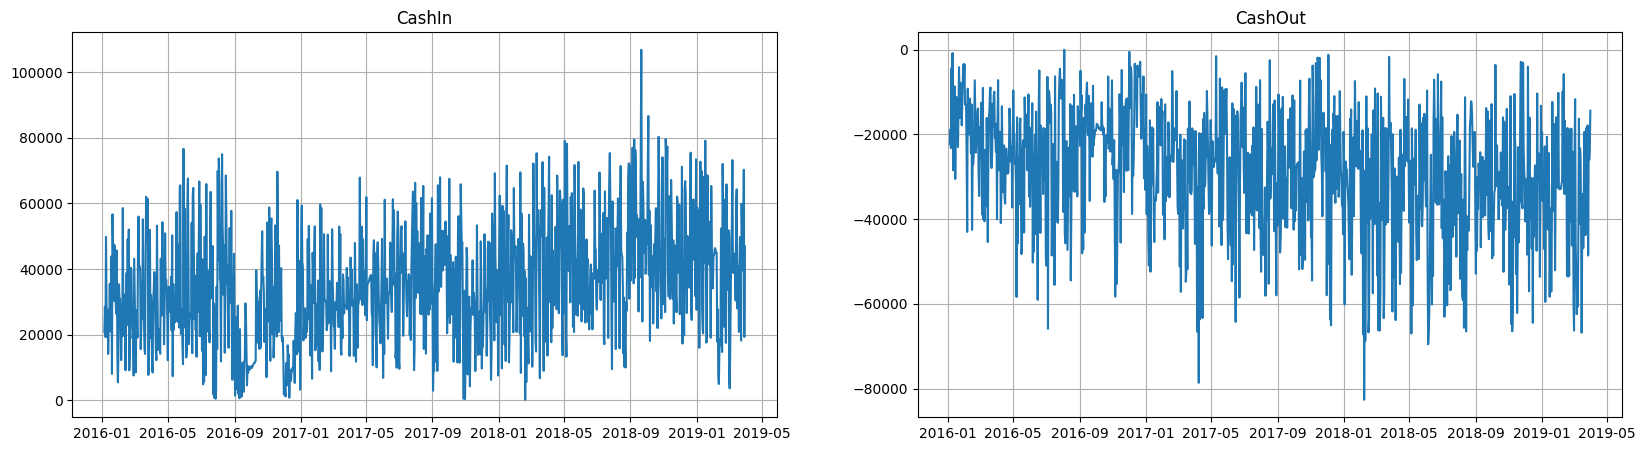

In [43]:
#Уберем оутлайеры
outliers_remover = DensityOutliersTransform(in_column="target", window_size=18, distance_coef=1, n_neighbors=4)

outliers_imputer = TimeSeriesImputerTransform(
    in_column="target", strategy = "running_mean", window=21
)
hier_ts.fit_transform([outliers_remover])
hier_ts.fit_transform([outliers_imputer])
hier_ts.plot()

In [44]:
bu_metrics, bu_forecasts, _ = pipeline.backtest(
    ts = hier_ts, metrics=[MAE()], aggregate_metrics=True, n_folds=4
)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphl58x9z9/_gm0gzif.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphl58x9z9/4iqegv3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71241', 'data', 'file=/tmp/tmphl58x9z9/_gm0gzif.json', 'init=/tmp/tmphl58x9z9/4iqegv3g.json', 'output', 'file=/tmp/tmpzra4x87a/prophet_model-20230518180250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:02:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:02:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True t

In [45]:
bu_metrics

,segment,MAE
0,target,14132.77533


### Задание 6. Построение признаков (1.5 балла)

Вернемся к нашему исходному мультисегментному ряду - теперь поработаем с моделями, которые требуют построения признаков - `ARIMA` и `CatBoost`. Построим для них признаки, и попробуем при помощи них добиться улучшения качества. Из обязательного: 1) постройте графики автокорреляции и при помощи них обоснуйте выбор лаговых признаков 2) для катбуста включите в признаки результаты STL разложения. Кроме этого, подумайте на экспертном уровне, какие закономерности могут присутствовать в пополнени наличности из банкомата? Снятии? Что из этого кажется более предсказуемым, и почему? Cделайте соответствующие признаки, и снабдите их кратким комментарием.

После этого, обучите на получившихся признаках модели.

Ниже приведены импорты, которые вам точно понадобятся - к ним необходимо добавить те инструменты, которые вы дополнительно решите использовать в анализе.

In [47]:
from etna.analysis import sample_acf_plot, sample_pacf_plot, stl_plot
from etna.ensembles import DirectEnsemble, StackingEnsemble, VotingEnsemble
from etna.models import (CatBoostMultiSegmentModel, CatBoostModelPerSegment,
                         AutoARIMAModel)
from etna.transforms import STLTransform, LagTransform, SegmentEncoderTransform

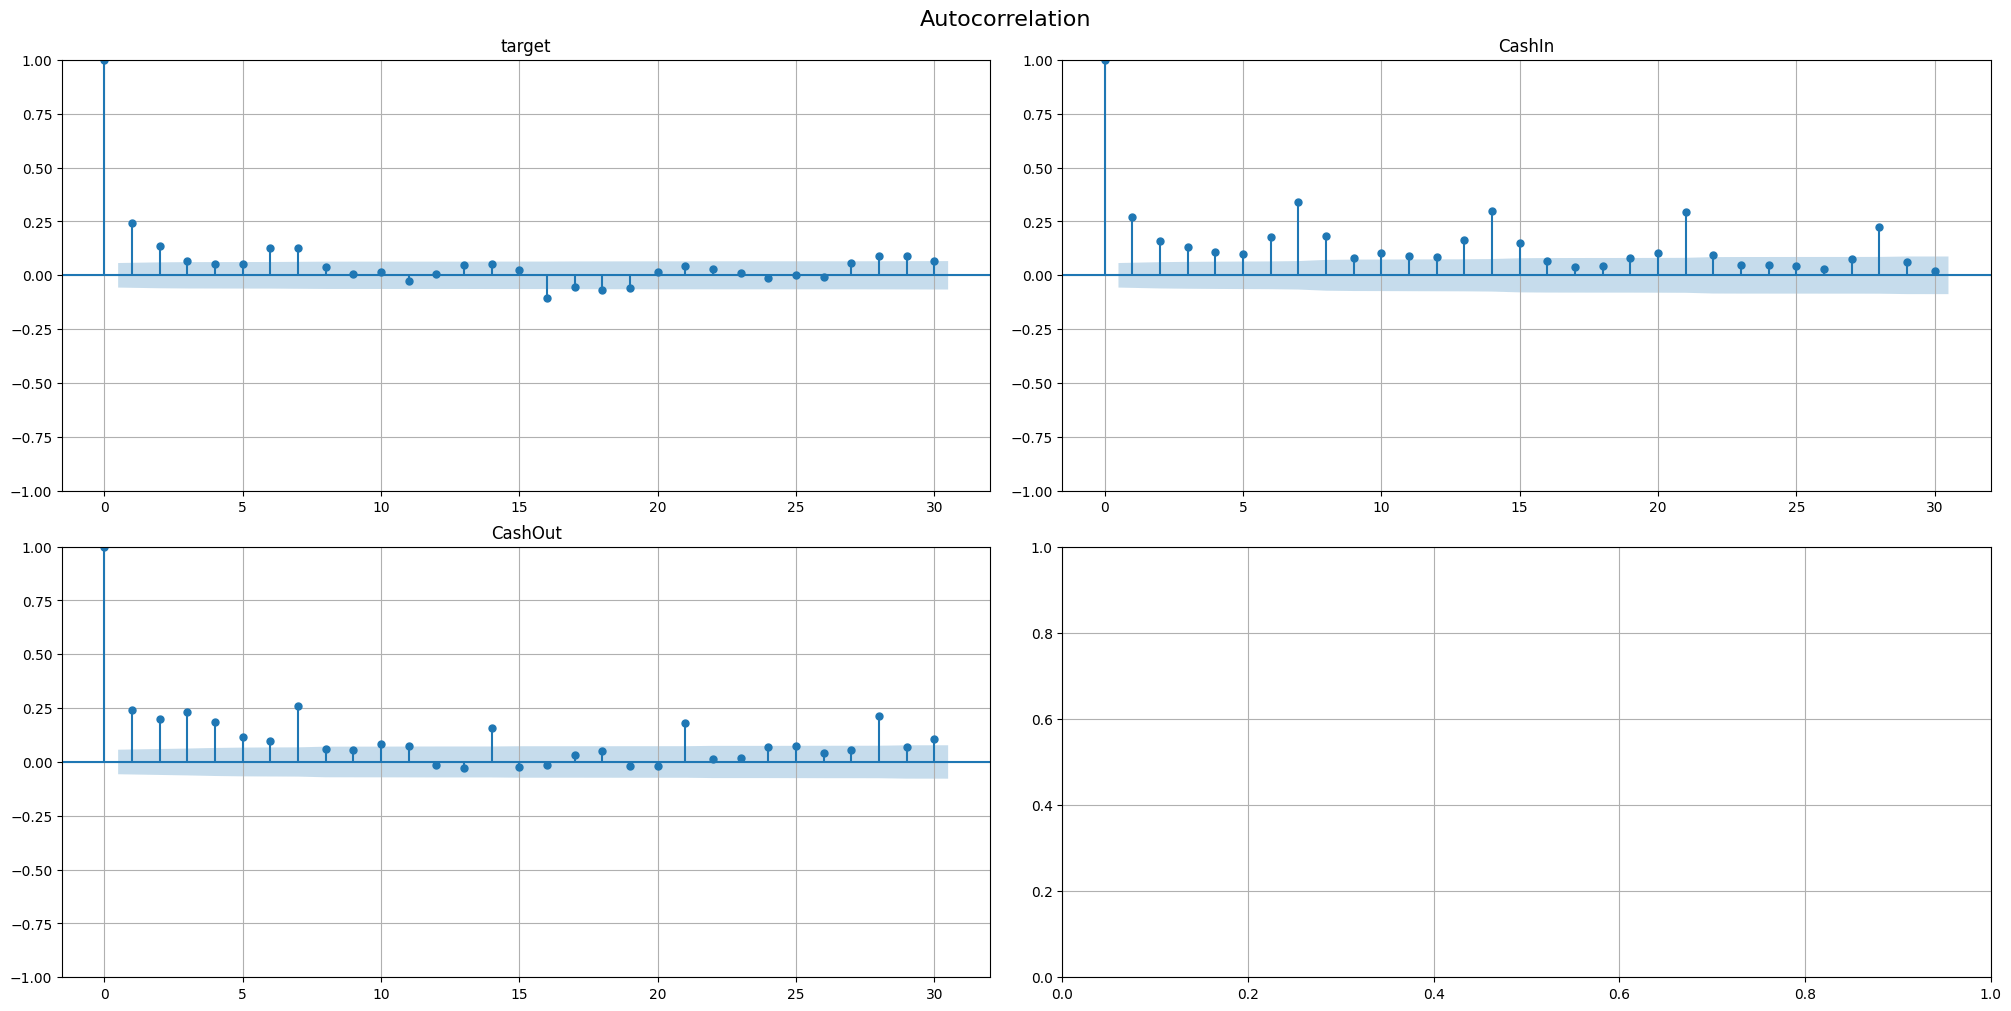

In [48]:
sample_acf_plot(ts, lags=30)

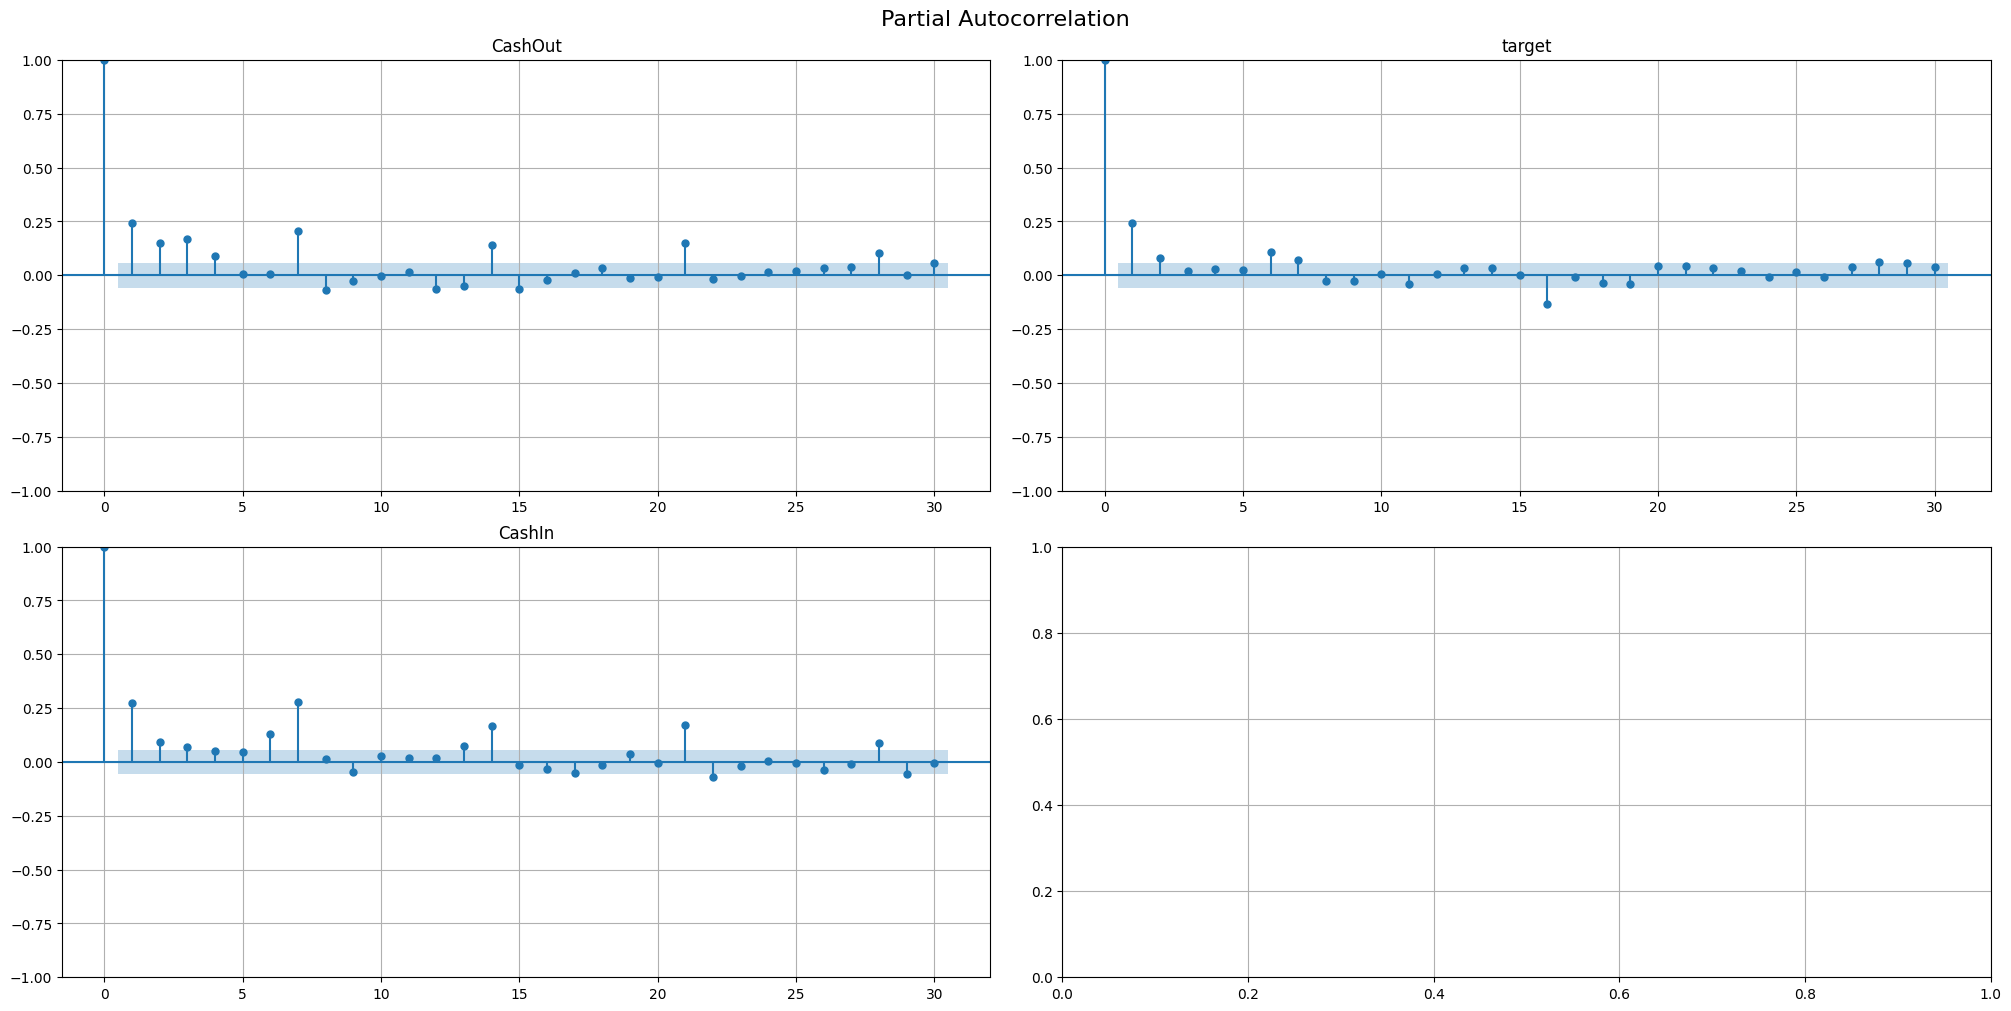

In [49]:

sample_pacf_plot(ts, lags=30)

In [50]:
pipeline_ARIMA = Pipeline(transforms = [LagTransform(in_column ='target', lags = [7, 8, 9, 10])], model = AutoARIMAModel(), horizon = HORIZON)
metrics_ARIMA, forecast_ARIMA, _ = pipeline_ARIMA.backtest(ts = ts, metrics = [MAE()], n_folds =2)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min finished


NameError: ignored

In [51]:
metrics_ARIMA

,segment,MAE,fold_number
0,CashIn,10295.506359,0
0,CashIn,14252.553103,1
1,CashOut,9193.944181,0
1,CashOut,12836.800334,1
2,target,12015.192159,0
2,target,19422.955957,1


In [53]:
pipeline_cat = Pipeline(transforms = [SegmentEncoderTransform(), LagTransform(in_column ='target', lags = [7, 8, 9, 10]), STLTransform(in_column = 'target', period=7, model = 'arima')], model = CatBoostModelPerSegment(), horizon = HORIZON)
metrics_cat, forecast_cat, _ = pipeline_cat.backtest(ts = ts, metrics = [MAE()], n_folds =2)
metrics_cat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.5s finished


,segment,MAE,fold_number
0,CashIn,12743.951479,0
0,CashIn,12535.124778,1
1,CashOut,8540.640465,0
1,CashOut,12237.574037,1
2,target,15463.152482,0
2,target,25882.047055,1


In [54]:
pipeline_cat = Pipeline(transforms = [SegmentEncoderTransform(), LagTransform(in_column ='target', lags = [7, 8, 9, 10]), STLTransform(in_column = 'target', period=7, model = 'arima')], model = CatBoostMultiSegmentModel(), horizon = HORIZON)
metrics_cat, forecast_cat, _ = pipeline_cat.backtest(ts = ts, metrics = [MAE()], n_folds =2)
metrics_cat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.3s finished


,segment,MAE,fold_number
0,CashIn,11715.843217,0
0,CashIn,13180.039378,1
1,CashOut,9401.183243,0
1,CashOut,12590.278890,1
2,target,15702.500500,0
2,target,22719.638227,1


### Задание 7. Стратегии прогнозирования (1.25 балла)

Как нам известно по семинарским занятиям, при построении прогноза на горизонте дальше следующего наблюдения перед нами встает задача определиться со стратегией генерации прогноза. Попробуйте разные стратегии на нашем горизонте из 5 дней (прямая, рекурсивная, смешанная dirrec). Какая стратегия в совокупности с какой моделью дает лучший результат?

Учитывайте особенности, которые некоторые стратегии могут накладывать на признаки (в частности, на лаговые переменные).

При необходимости, в смешанном методе пользуйтесь упрощенной схемой спецификации моделей/преобразований.

In [ ]:
from etna.pipeline import AutoRegressivePipeline, Pipeline, assemble_pipelines
from etna.ensembles import DirectEnsemble

In [ ]:
#YOUR CODE HERE#

### Задание 8. Ансамбли (1.25 балла)

Чтобы не выбирать лучшую модель, мы можем использовать преимущества каждой - давайте объединим все наши наработки в ансамбль. Попробуйте различные опции ансамблирования, и выберите ту, которая работает лучше всего (не забывайте, что внутри каждого ансамбля у нас тоже есть параметры, которые мы можем варьировать - веса в voting, включаемые признаки в stacking).

In [ ]:
from etna.ensembles import StackingEnsemble, VotingEnsemble

In [ ]:
#YOUR CODE HERE#

### Задание 9*. Трансформер (бонус 2 балла)

Для желающих протестировать мощь трансформенных моделей предлагается "завести" модель из второго семинара по временным рядам на текущем датасете. На этот раз абсолютно все необходимые импорты и зависимости подгружаются на ваше усмотрение. Удалось ли вам улучшить качество по сравнению с классическими моделями / моделями на основе ML? Что бы вы предпочли внедрить в production?

*NB:* все, конечно, прекрасно знают механизм работы бонусных заданий, но порядка ряди прописать дисклеймер должны - итоговый балл за домашнее задание ставится по формуле min(10, ваш суммарный балл за задания).

In [ ]:
#YOUR CODE HERE#